<a href="https://colab.research.google.com/github/shizoda/education/blob/main/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Colab用 Stable Diffusion 画像生成プロセス可視化プログラム

# 必要なライブラリのインストール
!pip install diffusers transformers accelerate torch matplotlib ipywidgets

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from tqdm.auto import tqdm
import ipywidgets as widgets
from PIL import Image

# CUDAが使用可能か確認
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda
Loading Stable Diffusion model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Example 1: Simple generation with visualization
Generating image with prompt: 'a serene Japanese garden with cherry blossoms'
Steps: 30, Guidance Scale: 7.5


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:899: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:905: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/30 [00:00<?, ?it/s]

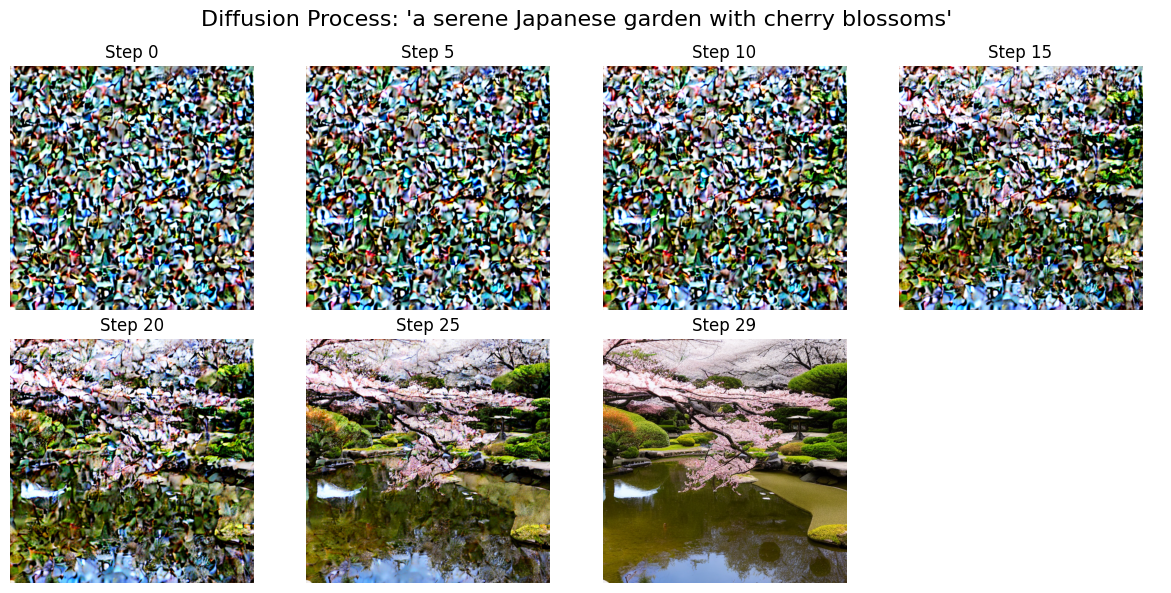

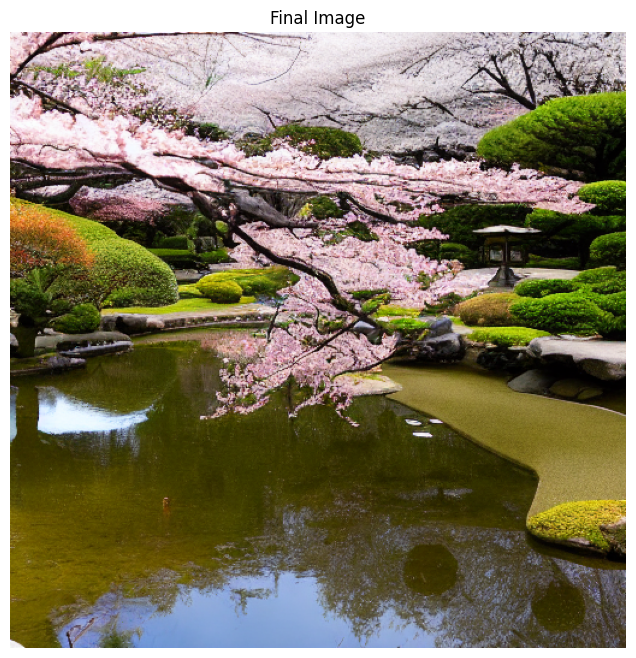


Interactive UI is ready! Adjust parameters and click 'Generate Image'


In [3]:

# Stable Diffusionパイプラインの初期化
# より高速な推論のためにDDIMSchedulerを使用
print("Loading Stable Diffusion model...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,  # 安全性チェッカーを無効化（より高速）
    requires_safety_checker=False
)

# DDIMSchedulerに変更（より少ないステップで良い結果が得られる）
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

# メモリ効率化
if device == "cuda":
    pipe.enable_attention_slicing()

def visualize_diffusion_process(
    prompt,
    negative_prompt="",
    num_inference_steps=50,
    guidance_scale=7.5,
    width=512,
    height=512,
    seed=42,
    show_every_n_steps=5
):
    """
    拡散過程を可視化しながら画像を生成

    Parameters:
    -----------
    prompt : str
        生成したい画像の説明
    negative_prompt : str
        避けたい要素の説明
    num_inference_steps : int
        推論ステップ数（多いほど品質が向上するが時間がかかる）
    guidance_scale : float
        プロンプトへの忠実度（高いほどプロンプトに忠実）
    width : int
        生成画像の幅
    height : int
        生成画像の高さ
    seed : int
        乱数シード（再現性のため）
    show_every_n_steps : int
        何ステップごとに表示するか
    """

    # シードの設定
    generator = torch.Generator(device=device).manual_seed(seed)

    # 中間結果を保存するリスト
    intermediate_images = []

    # カスタムコールバック関数
    def callback_fn(step, timestep, latents):
        if step % show_every_n_steps == 0 or step == num_inference_steps - 1:
            # latentsをRGB画像に変換
            with torch.no_grad():
                image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
                image = (image / 2 + 0.5).clamp(0, 1)
                # CPUに移動して、numpy配列に変換
                image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
                # float32型で、0-1の範囲であることを確認
                image = np.clip(image, 0, 1).astype(np.float32)
                intermediate_images.append((step, image))
        return {}

    # 画像生成の実行
    print(f"Generating image with prompt: '{prompt}'")
    print(f"Steps: {num_inference_steps}, Guidance Scale: {guidance_scale}")

    with torch.autocast(device):
        output = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            width=width,
            height=height,
            generator=generator,
            callback=callback_fn,
            callback_steps=1
        )

    final_image = output.images[0]

    # 結果の可視化
    n_images = len(intermediate_images)
    n_cols = min(4, n_images)  # 最大4列
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    # axesを1次元配列に変換
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for idx, (step, img) in enumerate(intermediate_images):
        axes[idx].imshow(img)
        axes[idx].set_title(f"Step {step}")
        axes[idx].axis('off')

    # 余った軸を非表示
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Diffusion Process: '{prompt}'", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 最終画像を大きく表示
    plt.figure(figsize=(8, 8))
    plt.imshow(final_image)
    plt.title("Final Image")
    plt.axis('off')
    plt.show()

    return final_image, intermediate_images

# インタラクティブなUI作成
def create_interactive_ui():
    """Google Colab用のインタラクティブなUIを作成"""

    # ウィジェットの作成
    prompt_widget = widgets.Textarea(
        value="a beautiful landscape with mountains and a lake at sunset",
        placeholder="Enter your prompt here",
        description="Prompt:",
        layout=widgets.Layout(width='80%', height='60px')
    )

    negative_prompt_widget = widgets.Textarea(
        value="blurry, ugly, distorted",
        placeholder="Enter negative prompt here",
        description="Negative:",
        layout=widgets.Layout(width='80%', height='40px')
    )

    steps_widget = widgets.IntSlider(
        value=30,
        min=10,
        max=100,
        step=5,
        description="Steps:",
        style={'description_width': 'initial'}
    )

    guidance_widget = widgets.FloatSlider(
        value=7.5,
        min=1.0,
        max=20.0,
        step=0.5,
        description="Guidance Scale:",
        style={'description_width': 'initial'}
    )

    show_every_widget = widgets.IntSlider(
        value=5,
        min=1,
        max=10,
        step=1,
        description="Show every N steps:",
        style={'description_width': 'initial'}
    )

    seed_widget = widgets.IntText(
        value=42,
        description="Seed:",
        style={'description_width': 'initial'}
    )

    generate_button = widgets.Button(
        description="Generate Image",
        button_style='primary',
        layout=widgets.Layout(width='200px', height='40px')
    )

    output_widget = widgets.Output()

    def on_generate_clicked(b):
        with output_widget:
            clear_output(wait=True)
            visualize_diffusion_process(
                prompt=prompt_widget.value,
                negative_prompt=negative_prompt_widget.value,
                num_inference_steps=steps_widget.value,
                guidance_scale=guidance_widget.value,
                show_every_n_steps=show_every_widget.value,
                seed=seed_widget.value
            )

    generate_button.on_click(on_generate_clicked)

    # UIのレイアウト
    ui = widgets.VBox([
        widgets.HTML("<h2>Stable Diffusion Image Generation Visualizer</h2>"),
        prompt_widget,
        negative_prompt_widget,
        widgets.HBox([steps_widget, guidance_widget]),
        widgets.HBox([show_every_widget, seed_widget]),
        generate_button,
        output_widget
    ])

    return ui

# シンプルなバージョン（エラーが出た場合の代替案）
def simple_generate(prompt, steps=30):
    """シンプルな画像生成（可視化なし）"""
    with torch.autocast(device):
        image = pipe(
            prompt=prompt,
            num_inference_steps=steps,
            guidance_scale=7.5
        ).images[0]

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Generated: {prompt}")
    plt.axis('off')
    plt.show()

    return image

Example 1: Simple generation with visualization
Generating image with prompt: 'a garden with sunflowers'
Steps: 30, Guidance Scale: 7.5


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:899: FutureWarning: `callback` is deprecated and will be removed in version 1.0.0. Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(
/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:905: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/30 [00:00<?, ?it/s]

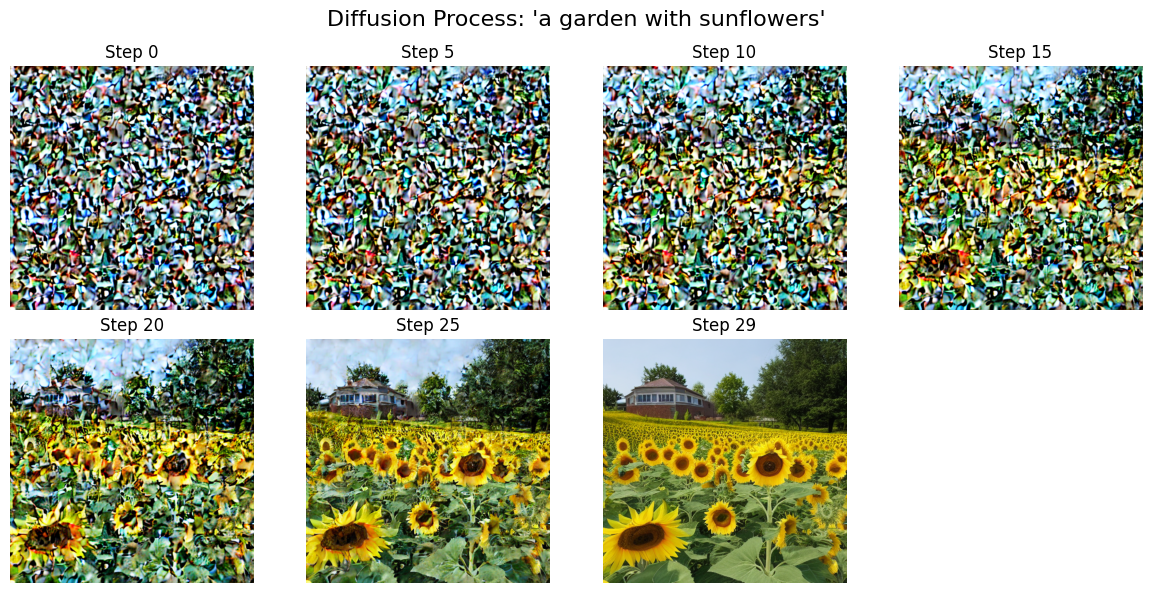

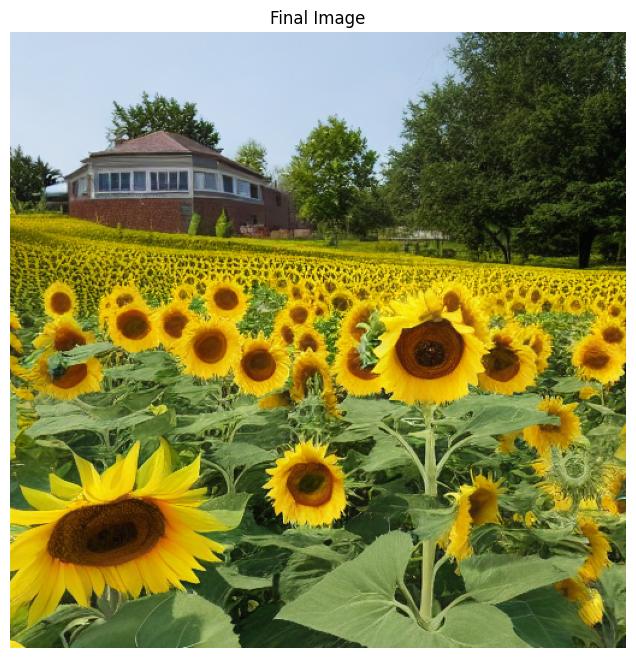

In [7]:
# 使用例1: シンプルな実行
print("Example 1: Simple generation with visualization")
try:
    final_image, intermediate_images = visualize_diffusion_process(
        prompt="a garden with sunflowers",
        negative_prompt="ugly, blurry, distorted",
        num_inference_steps=30,
        show_every_n_steps=5
    )
except Exception as e:
    print(f"Error occurred: {e}")
    print("Falling back to simple generation...")
    final_image = simple_generate("a garden with sunflowers")


In [8]:
# 使用例2: インタラクティブUI
print("\n" + "="*50)
print("Interactive UI is ready! Adjust parameters and click 'Generate Image'")
ui = create_interactive_ui()
display(ui)


Interactive UI is ready! Adjust parameters and click 'Generate Image'
